# Vortex center glow

The aim of this simulation is to model the vortex center glow effect, which is caused to diffraction of the thermal emission from the environment outside the entrance pupil to the pupil image formed on the detector, by the vortex phase mask. 
To model the effect, several points outside the entrance pupil are taken and their intensity on the detector is evaluated. Net effect is determined by adding contributions from all these points.

### Imports

In [81]:
import heeps
from heeps.optics.lens import lens, lens_offset
from heeps.optics.vortex_init import vortex_init
from heeps.util.coord import cart_coord, polar_coord
from heeps.util.img_processing import resize_img, crop_img, pad_img, get_radial_profile
from heeps.optics import lyot_stop, detector
from copy import deepcopy
import proper
import numpy as np
np.set_printoptions(threshold=np.inf, linewidth=200)
import os.path
from astropy.io import fits
import matplotlib.pyplot as plt
import multiprocessing as mpro
from functools import partial
from sys import platform
import time
%matplotlib inline

### Input parameters

In [82]:
diam_ext_cold_stop = 40.944
diam_int_cold_stop = 7.363
diam_ext_eff = 37.812
diam_int_eff = 10.196
r_spot = 0.1 # m
rad = 4.998
theta = 60
ncrop = 101 # for psf visualization
#Roy's input
flux_env_per_m2 = 1.213e+03 # [photons/s/m2/pix]
flux_spi_per_m2 = 1.001e+03 # [photons/s/m2/pix]
flux_env = 3.3403e+05 # [photons/s/pix]
flux_spi = 4.47823e+04 # [photons/s/pix]

### Initialize wavefront using PROPER

In [83]:
conf = dict(
#    dir_current = '/Users/cdelacroix/dox/METIS/METIS_HCI_HEEPS_simulations/VCG',
    band = 'L',
    mode = 'CVC',
    file_lyot_stop = 'pupil/ls_VCG_293_spi_0.54.fits',
    dir_output = 'VCG',
    cpu_count = None,
    hfov = 2.8,
    pupil_img_size = diam_ext_cold_stop + 2*r_spot,
    diam_ext = diam_ext_cold_stop, 
    diam_int = diam_int_cold_stop,
    )
conf = heeps.config.read_config(verbose=False, **conf)
conf = heeps.config.update_config(saveconf=True, verbose=True, **conf)
dir_current = conf['dir_current']
dir_output = conf['dir_output']
npupil = conf['npupil']
ngrid = conf['ngrid']
diam_ext = conf['diam_ext']
pupil_img_size = conf['pupil_img_size']
lam = conf['lam']
pscale = conf['pscale']
spi_width = conf['spi_width']
ndet = conf['ndet']
cpu_count = conf['cpu_count']
beam_ratio = npupil/ngrid*(diam_ext/pupil_img_size)
wf = proper.prop_begin(pupil_img_size, lam, ngrid, beam_ratio)

Simulation config: band=L, mode=CVC
‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
   loading vortex back-propagation params
   vc_charge=2, ngrid=1024, beam_ratio=0.2847
   npupil=293, pscale=5.47 mas, lam=3.8133E-06 m
   hfov=2.8 arcsec (-> ndet=1023, 145.65 lam/D)



### Create cold stop

(293, 293)


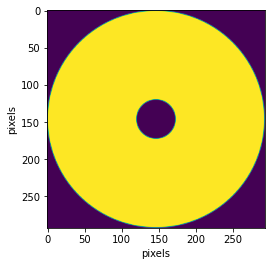

In [84]:
conf_stop = dict(conf, spi_width=0, seg_width=0)
cold_stop = heeps.pupil.create_pupil(**conf_stop)
print(cold_stop.shape)
plt.imshow(cold_stop), plt.xlabel('pixels'), plt.ylabel('pixels');
cold_stop = pad_img(cold_stop, ngrid)

### Create a spot, normalized by square meter of surface

In [85]:
def create_spot(rad, theta, nimg=10526):
    x, y = cart_coord(nimg)
    x *= pupil_img_size/2
    y *= pupil_img_size/2
    c = (rad*np.cos(np.deg2rad(theta)), rad*np.sin(np.deg2rad(theta)))
    r =  np.abs((x-c[0]) + 1j*(y-c[1]))
    spot = (r <= r_spot)                    # create a spot
    spot = resize_img(spot, npupil)         # resize to npupil
    spot = pad_img(spot, ngrid)             # pad with zeros
    # normalize the entrance pupil intensity (total flux = 1/spot_area)
    I_spot = spot**2
    spot_area = np.pi*r_spot**2
    spot = np.sqrt(I_spot/spot_area)
    return spot

### vortex phase mask(VPM)

In [86]:
def fp_mask(wf, rad, mode='RAVC', focal=660, vc_zoffset=1e-3/2, verbose=False, **conf):
        if verbose is True:
            print('   apply vortex phase mask')                        
        # update conf
        conf.update(focal=focal)
        # propagate to vortex
        lens_offset(wf, focal, offset_after=vc_zoffset)
        # load vortex calibration files: psf_num, vvc, perf_num
        conf = vortex_init(verbose=verbose, **conf)
        # intensity before rescaling
        int_distri = (proper.prop_get_amplitude(wf))**2
        print('Intensity at CFO-PP2, before rescaling = %s photons/s/m\u00b2'%np.sum(int_distri))
        # get maximum aplitude 
        amp_array = proper.prop_get_amplitude(wf)
        amp_max = np.amax(amp_array) 
        print('Intensity of the pixel with max. intensity = %s photons/s/m\u00b2/pix'%"{:.2E}".format(amp_max**2))
        #rescale flux
        if rad in np.arange(diam_ext_eff/2 + r_spot, diam_ext_cold_stop/2 + r_spot, 2*r_spot):
            proper.prop_multiply(wf, np.sqrt(flux_spi_per_m2)/amp_max)
            print('Intensity of the pixel with max. intensity, rescaled to %s photons/s/m\u00b2/pix'%"{:.2E}".format((np.amax(proper.prop_get_amplitude(wf)))**2))
        else:
            proper.prop_multiply(wf, np.sqrt(flux_env_per_m2)/amp_max)
            print('Intensity of the pixel with max. intensity, rescaled to %s photons/s/m\u00b2/pix'%"{:.2E}".format((np.amax(proper.prop_get_amplitude(wf)))**2))
        # intensity before vortex
        int_distri = (proper.prop_get_amplitude(wf))**2
        c = int(int_distri.shape[0]/2)
        rad_prof_before_vpm = get_radial_profile(int_distri, (c,c), nbin=1)
        radius_before_vpm = (np.arange(c+1)/c)*c*pscale/1000
        print('Intensity just before VPM = %s photons/s/m\u00b2'%"{:.2E}".format(np.sum(int_distri)))
        # apply vortex
        scale_psf = wf._wfarr[0,0]/conf['psf_num'][0,0]
        wf_corr = (conf['psf_num']*conf['vvc'] - conf['perf_num'])*scale_psf
        wf._wfarr = wf._wfarr*conf['vvc'] - wf_corr
        # intensity after vortex
        int_distri = (proper.prop_get_amplitude(wf))**2
        print('Intensity just after VPM = %s photons/s/m\u00b2'%"{:.2E}".format(np.sum(int_distri)))
        # propagate to lyot stop
        lens_offset(wf, focal, offset_before=-vc_zoffset)
        return wf, rad_prof_before_vpm, radius_before_vpm

### Propagate spot

#### create a normalized spot

In [87]:
spot = create_spot(rad, theta)
print('Intensity of the spot = %s photons/s/m\u00b2'%np.sum(spot**2))
#plt.imshow(spot)

Intensity of the spot = 17.727089 photons/s/m²


#### add spot to wavefront

In [88]:
# keep a copy of the input wavefront
wf1 = deepcopy(wf)
# add spot to wavefront
proper.prop_multiply(wf1, spot)
int_distri = (proper.prop_get_amplitude(wf1))**2
print('Intensity at the entrance pupil = %s photons/s/m\u00b2'%np.sum(int_distri))
#plt.imshow(int_distri)

Intensity at the entrance pupil = 17.727086919626096 photons/s/m²


#### apply cold stop

In [89]:
proper.prop_multiply(wf1, cold_stop)
int_distri = (proper.prop_get_amplitude(wf1))**2
print('Intensity after cold stop = %s photons/s/m\u00b2'%np.sum(int_distri))
#plt.imshow(int_distri)

Intensity after cold stop = 17.727086919626096 photons/s/m²


#### apply vortex phase mask (VPM)

Intensity at CFO-PP2, before rescaling = 17.727086919626103 photons/s/m²
Intensity of the pixel with max. intensity = 7.71E-05 photons/s/m²/pix
Intensity of the pixel with max. intensity, rescaled to 1.21E+03 photons/s/m²/pix
Intensity just before VPM = 2.79E+08 photons/s/m²
Intensity just after VPM = 2.79E+08 photons/s/m²


Text(0.5, 0, 'Distance from center (arcsec)')

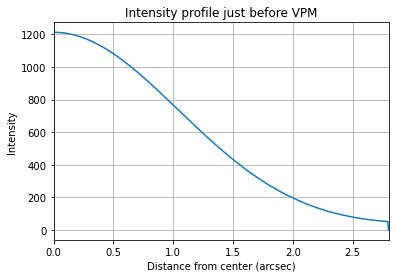

In [90]:
wf1, rad_prof_before_vpm, radius_before_vpm = fp_mask(wf1, rad, **conf)
int_distri = (proper.prop_get_amplitude(wf1))**2
plt.grid(True)
plt.plot(radius_before_vpm, rad_prof_before_vpm, )
plt.xlim(0.0, radius_before_vpm[-1])
plt.title('Intensity profile just before VPM')
plt.ylabel('Intensity')  
plt.xlabel('Distance from center (arcsec)')
#plt.imshow(int_distri)

#### apply lyot stop

Intensity after lyot stop = 1.68E+06 photons/s/m²


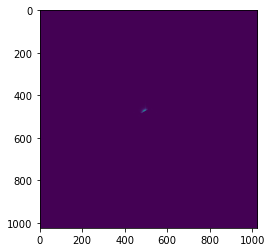

In [91]:
wf1 = lyot_stop(wf1, **conf)
#int_distri = (proper.prop_get_amplitude(wf1))**2
int_distri = (proper.prop_get_amplitude(wf1))**2
print('Intensity after lyot stop = %s photons/s/m\u00b2'%"{:.2E}".format(np.sum(int_distri)))
plt.imshow(int_distri)

#### propogate to detector

Intensity at the detector = 1.68E+06 photons/s/m²
Intensity of the pixel with max. intensity = 2.54E+03 photons/s/m²/pix


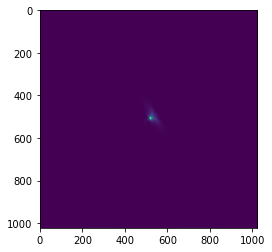

In [92]:
psf = detector(wf1, **conf)
print('Intensity at the detector = %s photons/s/m\u00b2'%"{:.2E}".format(np.sum(psf)))
print('Intensity of the pixel with max. intensity = %s photons/s/m\u00b2/pix'%"{:.2E}".format(np.amax(psf)))
plt.imshow(psf)